In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Szeged*, Hungary Weather

This notebook is gonna walk through an analysis of weather data from Szeged*, Hungary.  The analysis will lead up to a linear regression model that predicts temperature.

<sub>*(according to every submitted pronunciation [here](https://forvo.com/word/szeged/), the city is pronounced kinda like 'sehged')</sub>

### But first!  Warm up 🥵

* Q: How does the ROC curve differ in binary and multi-class classification?
  * A: Make 1 ROC per class|
  
* Bonus warm-up 🥵!

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

# Gen data
n = 5000
y = np.random.choice([0, 1, 2], n)
x1 = np.random.normal(10, 5, n)
x2 = np.random.normal(5, 3, n)

# Shift xs by class to make more easily separable
x1[np.where(y == 0)] += 5
x1[np.where(y == 1)] -= 5
x2[np.where(y == 0)] += 5
x2[np.where(y == 2)] -= 5

df = pd.DataFrame({"x1": x2, "x2": x1, "y": y})
df.head()

* Plot `x1` by `x2` and color by `y`

* Perform a train/test split with 20% of the data in test set

* Fit a logistic regression model (use whatever hyperparameters you'd like)

* Score your model and report fitting issues (i.e. under/over)

* Display a confusion matrix and a classification report.
  * When classifying an actual class 0, what mistake is the model most likely to make?
  * What 2 classes are the hardest to separate? Does this make sense based on the scatter plot?
  * What class has the highest recall? What does that mean? Does this make sense based on the scatter plot?

## General EDA

We'll start with loading the data and doing some intro EDA.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# CSV downloaded from https://www.kaggle.com/budincsevity/szeged-weather
data_url = "https://docs.google.com/spreadsheets/d/1VI1rDsUI7KTMUEyDgV8cc0gLdwYr1p_aCwyyp3Mz3_M/export?format=csv"
szeged = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Get to know the data.  Keep in mind, the end goal is to be able to predict temperature.

In [6]:
szeged.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


<IPython.core.display.Javascript object>

In [5]:
szeged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  int64  
 8   Visibility (km)           96453 non-null  float64
 9   Cloud Cover               96453 non-null  int64  
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 8.8+ MB


<IPython.core.display.Javascript object>

### Tangent start

*click here to jump to [Tangent end](#Tangent-end)*

My guess going in would be that a lack of precipitation would appear as an `NA` here, but that's a suspiciously low percentage for a lack of precipitation.  I will concede, I'm not familiar with Hungary's weather, maybe it does rain there 99.5% of the time.

We could:
  * Drop them.. It's a low percentage of our records, but maybe there's value to be had?
  * look at the data's documenation (should probably start here... but we won't...)
  * look at the `value_counts` of the `Precip Type` column.
  * look at the other column values when `Precip Type` is `NA`
  * Look at a `crosstab` of `Precip Type` and a column like `Summary`

Show the value counts of the `Precip Type` column, use an argument to avoid excluding NaN from this output

In [11]:
szeged["Precip Type"].value_counts(dropna=False)

rain    85224
snow    10712
NaN       517
Name: Precip Type, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
szeged["Precip Type"].value_counts

Show the head of the data when `Precip Type` is NaN

In [13]:
szeged[szeged["Precip Type"].isna()].head(20)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Daily Summary
52672,2012-04-11 16:00:00.000 +0200,Mostly Cloudy,NaN,19.016667,19.016667,0.26,14.8764,163,9.9820,0,1002.40,Mostly cloudy until night.
52674,2012-04-11 18:00:00.000 +0200,Mostly Cloudy,NaN,17.850000,17.850000,0.28,13.7977,169,9.9820,0,1001.79,Mostly cloudy until night.
52675,2012-04-11 19:00:00.000 +0200,Mostly Cloudy,NaN,16.322222,16.322222,0.32,10.8192,151,9.9820,0,1001.60,Mostly cloudy until night.
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,NaN,12.566667,12.566667,0.43,9.0160,159,9.9820,0,1001.92,Mostly cloudy until night.
52678,2012-04-11 22:00:00.000 +0200,Mostly Cloudy,NaN,12.927778,12.927778,0.47,17.6295,197,16.1000,0,1002.20,Mostly cloudy until night.
52680,2012-04-12 00:00:00.000 +0200,Mostly Cloudy,NaN,10.100000,10.100000,0.61,11.3666,180,16.1000,0,1002.25,Light rain in the morning.
52681,2012-04-12 01:00:00.000 +0200,Partly Cloudy,NaN,10.183333,10.183333,0.64,7.2128,150,16.1000,0,1002.05,Light rain in the morning.
52683,2012-04-12 03:00:00.000 +0200,Mostly Cloudy,NaN,10.700000,10.700000,0.70,14.6993,133,16.1000,0,1001.42,Light rain in the morning.
52684,2012-04-12 04:00:00.000 +0200,Partly Cloudy,NaN,9.744444,8.022222,0.73,11.9623,142,16.1000,0,1001.11,Light rain in the morning.
52687,2012-04-12 07:00:00.000 +0200,Mostly Cloudy,NaN,10.055556,10.055556,0.76,13.9748,213,11.1090,0,1001.22,Light rain in the morning.


<IPython.core.display.Javascript object>

Look at a `crosstab` of `Precip Type` and a column like `Summary` (include NaNs)

In [16]:
crosstab = pd.crosstab(szeged["Summary"], szeged["Precip Type"].fillna('NaN'))
crosstab.sort_values('NaN', ascending=False)


Precip Type,NaN,rain,snow
Summary,,,
Mostly Cloudy,180,26028,1886
Clear,127,9371,1392
Partly Cloudy,98,29915,1720
Overcast,81,13916,2600
Foggy,31,4135,2982
Breezy,0,42,12
Humid and Partly Cloudy,0,17,0
Windy and Overcast,0,42,3
Windy and Mostly Cloudy,0,35,0


<IPython.core.display.Javascript object>

A higher percentage of `NaN`s seem to be associated with clear weather than rain or snow.  It feels safe to conclude there's some relationship between `NaN`s and lack of precipitation.  We can confirm this by checking the documentation.  If we check the [Kaggle page](https://www.kaggle.com/budincsevity/szeged-weather) where this data was downloaded from, we see that this data was originally collected from the [darksky.net](https://darksky.net/) API.  Conveniently, this API has [some documentation](https://darksky.net/dev/docs#data-point-object) on all the values it can return.  The below is copied from the documentation about our `Precip Type` column.  So we see that if the `precipIntensity` is zero, we are expected to have a `NaN`.

> **`precipType`** *optional*
>
> The type of precipitation occurring at the given time. If defined, this property will have one of the following values: `"rain"`, `"snow"`, or `"sleet"` (which refers to each of freezing rain, ice pellets, and “wintery mix”). (If `precipIntensity` is zero, then this property will not be defined. Additionally, due to the lack of data in our sources, historical `precipType` information is usually estimated, rather than observed.)

So how do we use this information? We just went through a lot of work investigating, so what? Well now we know that doing a `dropna` would be needlessly losing records from the dataset.  These NaNs are legit records and we should keep them in the analysis by treating NaN as a legit category for the `precipType` column.

### Tangent end

Okie doke. Let's get down to brass tacks.  We want to predict temperature.  For today, we'll just use the `Humidity` and `Visibility (km)` features.  We can start to focus our EDA on these culprits.

Subset the dataframe to only the `"Temperature (C)"`, `"Humidity"`, and `"Visibility (km)"` columns.

In [31]:
X = szeged[["Humidity", "Visibility (km)"]]
y = szeged["Temperature (C)"]

<IPython.core.display.Javascript object>

Create a pairplot/scatter matrix of all three remaining columns. Do we see some correlations (especially with our target)?

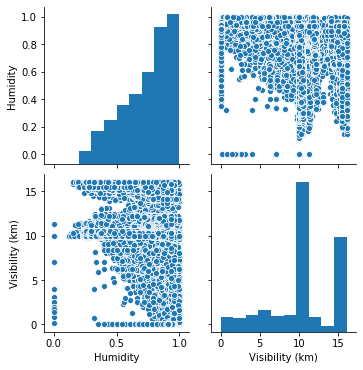

<IPython.core.display.Javascript object>

In [32]:
sns.pairplot(X)

(array([ 7564., 10262.,  8451., 43552., 26624.]),
 array([ 0.  ,  3.22,  6.44,  9.66, 12.88, 16.1 ]),
 <a list of 5 Patch objects>)

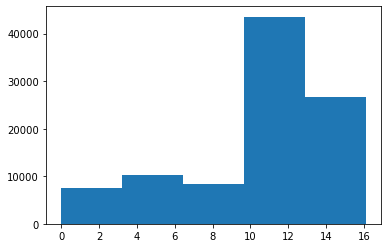

<IPython.core.display.Javascript object>

In [33]:
plt.hist(szeged["Visibility (km)"], bins=5)

Create a heatmap of the correlations between these three columns.

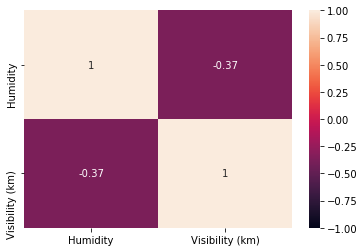

<IPython.core.display.Javascript object>

In [34]:
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)

We seem to have some predictive power within these two inputs.  Looking at the scatterplots we can see trends, and a heatmap confirms some correlation.  `Humidity` is more tightly coupled with `Temperature (C)` than `Visibility (km)`.

Perform a train test split; pick whatever parameters you want

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

Fit a linear regression model using `sklearn`

In [36]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

Score the model and report fitting issues (i.e. under/over).

In [37]:
model.score(X_train, y_train)

0.4301422070380665

<IPython.core.display.Javascript object>

In [38]:
model.score(X_test, y_test)

0.42534361377089425

<IPython.core.display.Javascript object>

Note: these scores aren't "accuracy" like it was for logistic regression.  This metric is called $R^2$.  In some ways it can be treated the same accuracy: the higher the better and a perfect score is `1.0`.

My model's $R^2$ on the test set is `0.43`.  This number is often interpreted like:
* "the model explains 43% of the variation in temperature"
* "humidity and visibility explain 43% of the variation".

Math-wise, this number is asking the question: 'Did we predict better than guessing the mean?'.  For a deeper dive on $R^2$ checkout the `understanding_r_squared.ipynb` notebook.

Our model's formula can be found in the `intercept_` and `coef_` attributes.  The trailing underscore is a convention in `sklearn` to mean the model's `fit` method will define them (i.e. we our model can't have coefficients until the model is fit, so they're stored in a trailing `_` attribute).

27.875206111953645
[-27.60214615   0.41986705]


<IPython.core.display.Javascript object>

Print out a string version of our linear regression model's formula
  * i.e. this might look like `Temp = 100 + (20) * Humidity + (2) * Visibility`


What does this formula tell us?  Does this make sense with the correlations/EDA we looked at?

In [40]:
inter = model.intercept_
a, b = model.coef_

print(f"Temp = {inter} + ({round(a,2)}) * Humidity + ({round(b,2)}) * Visibility")


Temp = 27.875206111953645 + (-27.6) * Humidity + (0.42) * Visibility


<IPython.core.display.Javascript object>

Use the model's predict method to make predictions on the test set

In [41]:
model.predict(X_test)

array([19.77609293,  9.1565377 , 13.9762071 , ..., 17.43718155,
       17.75602772, 15.95680912])

<IPython.core.display.Javascript object>

Create a dataframe with the input features, `y_test`, and the predictions for the test set

In [ ]:
y_pred = model.predict(X_test)
mistakes = y_pred - y_test
mistakes.abs().mean()

Let's look at a plot of our predictions vs our predictors.

Make a scatter plot with Humidity on the x axis and model predictions as the y axis 

Make a scatter plot with Visibility on the x axis and model predictions as the y axis

That's not very linear... Although linear regression is making 'linear combinations' of our variables, the output isn't a line when we have multiple predictors. Our current data has 3 dimensions (2 features and 1 target), so we'll need a visualization that can capture all 3 to fully make sense of it.  Color is a nice goto way to cheat 3 dims into a 2d plot.

Make a scatter plot with Humidity on the x axis, model predictions as the y axis, and color by visibility

Make a scatter plot with visibility on the x axis, model predictions as the y axis, and color by Humidity

In the case of 3d, we can actually plot this directly.  Note, 3d plots do not always provide more insight than a series of 2d plots; make sure to evaluate your use case on whether or not it fits.  Here, I think 3d plots help drive home the point that we have a plane of predictions.  When we get above 3d this gets harder and harder to visualize.

In [ ]:
figure = px.scatter_3d(
    data_frame=pred_df, x="Humidity", y="Visibility (km)", z="predicted"
)


figure.update_traces(name="Predicted", showlegend=True)
figure.add_scatter3d(
    x=pred_df["Humidity"],
    y=pred_df["Visibility (km)"],
    z=pred_df["actual"],
    opacity=0.2,
    mode="markers",
    name="Actuals",
)

figure.show()